In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
#create the colormap we want: white -> blue -> red

colors = [(1, 1, 1), (0.78, 0.84, 0.94), (0.92, 0.69, 0.65)]  # R -> G -> B
n_bins = 20  # Discretizes the interpolation into bins
cmap_name = 'white_blue_red'

# Create the colormap
cmap_wbr = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


# Heatmap of compounds distribution after Mscluster and cosine filtering

In [8]:
# import mscluster results
validated = pd.read_csv('/.../output_cosine_check_after_clustering_adjustments.tsv', sep='\t')

# and filter for validation cos>0.7
filter_acyl_amides = (validated['comment'] == 'acyl_amides_library') & (validated['cosine_standard'] > 0.7)
filter_heads_only = (validated['comment'] == 'head_only') & (validated['cosine_shifted'] > 0.7)
validated = validated[filter_acyl_amides | filter_heads_only]

# keep only the columns that we need for the heatmap
validated = validated[['group_annotation','num_scans_cluster']]

# use groupby to sum up the scans
grouped_df = validated.groupby('group_annotation')['num_scans_cluster'].sum().reset_index()

# split into head and annotation column
grouped_df['annotation'] = grouped_df['group_annotation'].str.split('-').str[-1]
grouped_df['Head'] = grouped_df['group_annotation'].str.split('-C').str[0]

# create pivot table
pivot_table = grouped_df.pivot_table(
    index='annotation', 
    columns='Head', 
    values='num_scans_cluster', 
    aggfunc='sum'
).reset_index()

pivot_table = pivot_table.fillna(0)

# apply log transformation
columns_for_heatmap = pivot_table.columns[1:]
annotation_column = pivot_table['annotation']
pivot_table[columns_for_heatmap] = pivot_table[columns_for_heatmap] + 1 # sum 1 to avoid errors for log transformation
log_pivot_table = np.log10(pivot_table[columns_for_heatmap])
log_pivot_table = pd.concat([annotation_column, log_pivot_table], axis=1)

# put in ascending order of fatty acid chain length and unsaturations
annotation = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
log_pivot_table = pd.merge(log_pivot_table, annotation[['annotation', 'order']], on='annotation', how='outer')
log_pivot_table = log_pivot_table.fillna(0)
log_pivot_table = log_pivot_table.sort_values(by='order', ascending=True)
log_pivot_table = log_pivot_table.drop('order', axis=1)

# transpose
log_pivot_table = log_pivot_table.T.reset_index()
log_pivot_table.columns = log_pivot_table.iloc[0]
log_pivot_table = log_pivot_table[1:]

# make sure numbers are floats
columns_for_heatmap = log_pivot_table.columns[1:]
log_pivot_table[columns_for_heatmap] = log_pivot_table[columns_for_heatmap].astype(np.float64)


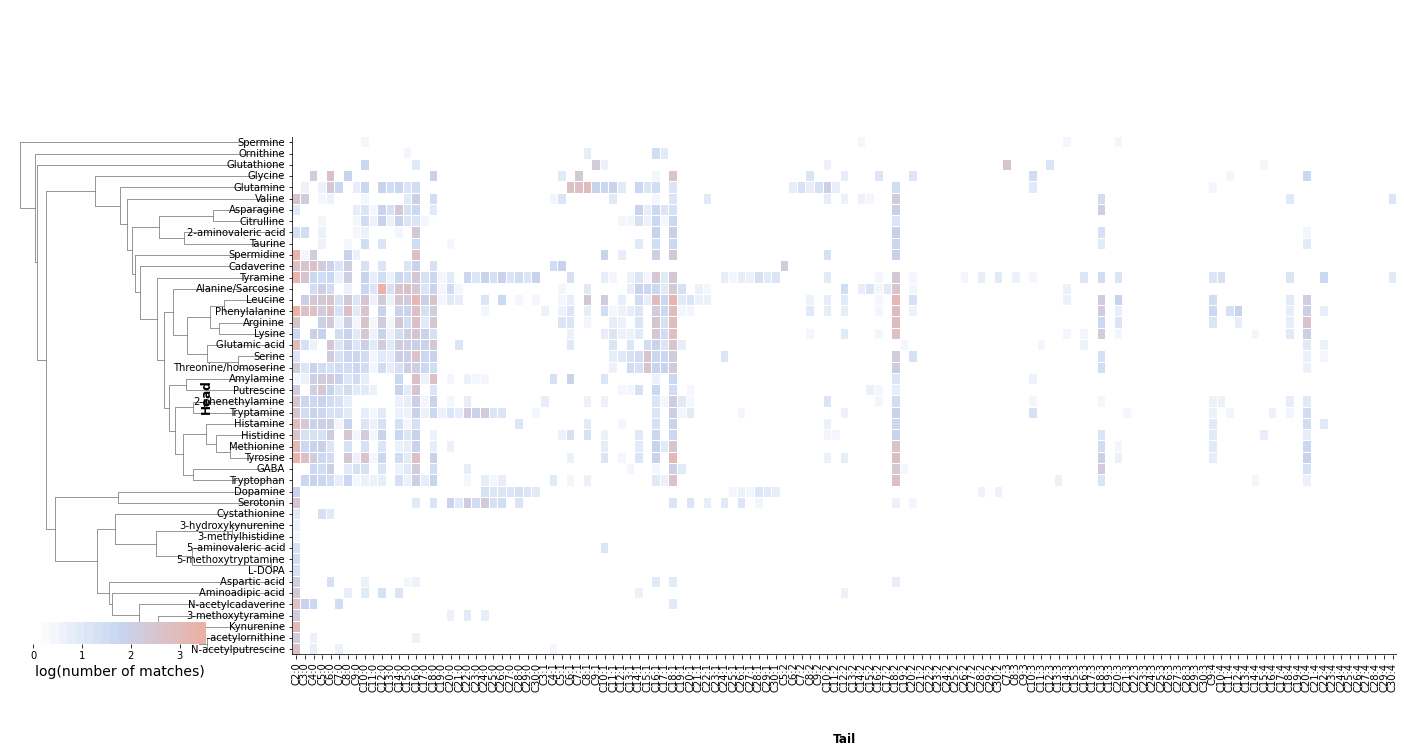

In [9]:
#### Heatmap

variable = 'annotation'

fig = sns.clustermap(
    log_pivot_table[columns_for_heatmap], 
    cmap=cmap_wbr,
    metric = 'braycurtis',
    col_cluster=False, 
    row_cluster=True,
    yticklabels=log_pivot_table[variable],
    linewidths=0.005,
    linecolor = 'white',
    xticklabels=1,
    cbar_kws={'orientation': 'horizontal'}
)

fig.ax_heatmap.yaxis.set_ticks_position('left')
fig.ax_heatmap.yaxis.set_label_position('left')
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)

fig.ax_heatmap.set_xlabel('Tail', fontsize=12, weight='bold')
fig.ax_heatmap.set_ylabel('Head', fontsize=12, weight='bold', labelpad=-40)

fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.15) #coordinate X axis - more to the bottom
line_count = len(log_pivot_table[variable].unique())
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=1.5)
fig.ax_heatmap.axvline(x=0, color='black', linewidth=1.5)

# colorbar
cax = fig.ax_cbar
cax.set_position([.03, .10, .1, .03])  # Adjust the position and size of the color bar
cbar = fig.ax_heatmap.collections[0].colorbar
cbar.set_label('log(number of matches)', fontsize=14)  # Set the desired font size for the color bar label

# adjust figure size and export
plt.gcf().set_size_inches(24, 10)
# fig.savefig('/.../Figure1b.pdf')


# Highlight compounds matched with microbeMASST and synthesized

In [10]:
# import compounds that matched microbemasst - after validation cos>0.7 and all the filters
microbes = pd.read_csv('/.../all_heads_microbes_after_all_filters.tsv', sep='\t')

# create a new column with annotation only
microbes['annotation'] = microbes['group_annotation'].str.split('-').str[-1]

# and just keep the information of the combination of head and tail that we will highlight in the heatmap
microbes = microbes[['Head', 'annotation']]
microbes = microbes.drop_duplicates()
microbes = microbes.reset_index()
microbes.head()

,index,Head,annotation
0,0,Ornithine,C17:1
1,3,Ornithine,C15:0
2,12,Ornithine,C16:1
3,27,Tyrosine,C2:0
4,46,Tyrosine,C14:0


In [11]:
# import compounds that were synthesized and also had a cos>0.7 of modified cosine similarity with the headgroup.
lib_synthesis = pd.read_csv('/.../lib_synthesis_final.tsv', sep='\t')

# import compounds that we had RT and MS/MS matching with biological samples
rt_matching = pd.read_csv('/.../compounds_RT_matching_final.txt', sep='\t')


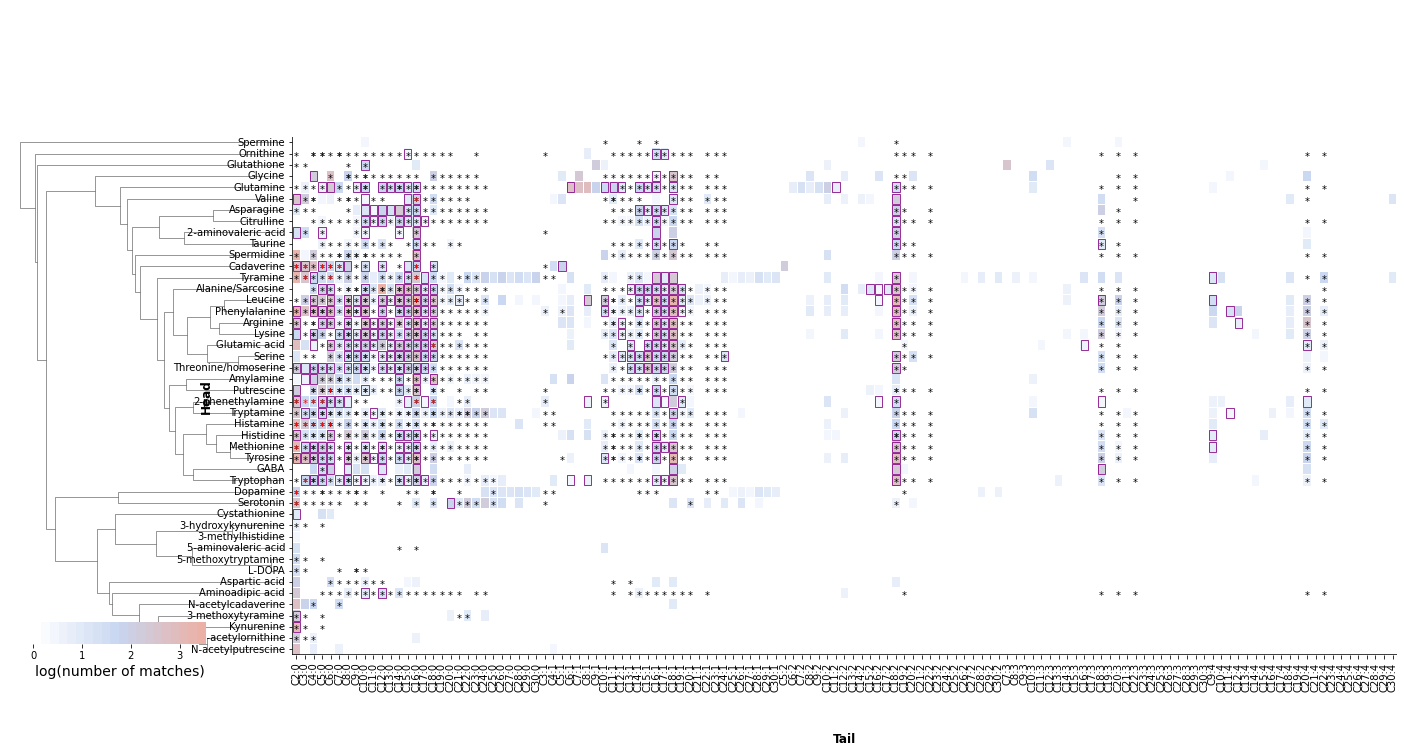

In [12]:
#### Heatmap

variable = 'annotation'

fig = sns.clustermap(
    log_pivot_table[columns_for_heatmap], 
    cmap=cmap_wbr,
    metric = 'braycurtis',
    col_cluster=False, 
    row_cluster=True,
    yticklabels=log_pivot_table[variable],
    linewidths=0.005,
    linecolor = 'white',
    xticklabels=1,
    cbar_kws={'orientation': 'horizontal'}
)

fig.ax_heatmap.yaxis.set_ticks_position('left')
fig.ax_heatmap.yaxis.set_label_position('left')
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)

fig.ax_heatmap.set_xlabel('Tail', fontsize=12, weight='bold')
fig.ax_heatmap.set_ylabel('Head', fontsize=12, weight='bold', labelpad=-40)

fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.15) #coordinate X axis - more to the bottom
line_count = len(log_pivot_table[variable].unique())
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=1.5)
fig.ax_heatmap.axvline(x=0, color='black', linewidth=1.5)

# colorbar
cax = fig.ax_cbar
cax.set_position([.03, .10, .1, .03])  # Adjust the position and size of the color bar
cbar = fig.ax_heatmap.collections[0].colorbar
cbar.set_label('log(number of matches)', fontsize=14)  # Set the desired font size for the color bar label

# adjust figure size and export
plt.gcf().set_size_inches(24, 10)


#############
# Function to higlight the cells based on the column/row names - microbeMASST matches as purple rectangles

def highlight_cell(column, row):
    col_highlight = fig.data2d.columns.to_list().index(column)
    row_highlight = fig.dendrogram_row.reordered_ind.index(log_pivot_table.index[log_pivot_table['annotation'] == row].tolist()[0] - 1)

    ax = fig.ax_heatmap
    ax.add_patch(Rectangle((col_highlight+0.065, row_highlight+0.05), 0.86, 0.90, fill=False, edgecolor='purple', lw=.8))
    

# Function to higlight the cells based on the column/row names - stars as synthetic standards and matching in
# biological samples
def annotate_df(column, row, text, offset=(0.5, 0,5), color='black'):
    if column in fig.data2d.columns.to_list() and row in log_pivot_table['annotation'].values:
        col_highlight = fig.data2d.columns.to_list().index(column)
        row_highlight = fig.dendrogram_row.reordered_ind.index(log_pivot_table.index[log_pivot_table['annotation'] == row].tolist()[0] - 1)
        fig.ax_heatmap.text(x=col_highlight+offset[0],y=row_highlight+offset[1],s=text,ha='center', color=color)    

# plot rectangles - microbeMASST
for i in range(len(microbes)):
    row = microbes.iloc[i]['Head']
    column = microbes.iloc[i]['annotation']
    highlight_cell(column, row)
    
# plot black stars - standards obtained via combinatorial synthesis
for i in range(len(lib_synthesis)):
    row = lib_synthesis.iloc[i]['Head']
    column = lib_synthesis.iloc[i]['annotation']
    annotate_df(column, row, '*', offset=(0.5,1.0), color='black')
    
# plot red stars - standards obtained via combinatorial synthesis and matched with retention time and MS/MS matching
# with biological samples
for i in range(len(rt_matching)):
    row = rt_matching.iloc[i]['Head']
    column = rt_matching.iloc[i]['annotation']
    annotate_df(column, row, '*', offset=(0.5,1.0), color='red')
    
    
fig.savefig('/.../Figure1b.pdf')
